# Data Preprocessing

In [2]:
from google.colab import drive
drive.mount('/content/drive')

from pathlib import Path

PROJECT_ROOT = Path("/content/drive/MyDrive/Bharde_429_Final")
PROJECT_ROOT.mkdir(parents=True, exist_ok=True)

ZIP_PATH = PROJECT_ROOT / "asl-alphabet.zip"

print("Project root:", PROJECT_ROOT)
print("Zip exists:", ZIP_PATH.exists())

Mounted at /content/drive
Project root: /content/drive/MyDrive/Bharde_429_Final
Zip exists: True


In [3]:
import shutil, os, subprocess

LOCAL_BASE  = Path("/content/asl_alphabet_unzipped")
LOCAL_TRAIN = LOCAL_BASE / "asl_alphabet_train"
LOCAL_TEST  = LOCAL_BASE / "asl_alphabet_test"

LOCAL_BASE.mkdir(parents=True, exist_ok=True)

if LOCAL_TRAIN.exists() and any(LOCAL_TRAIN.iterdir()):
    print("Using existing local unzipped data at:", LOCAL_TRAIN)
else:
    assert ZIP_PATH.exists(), "asl-alphabet.zip not found in PROJECT_ROOT."
    print("Unzipping from Drive zip -> /content ...")
    !unzip -q -o "{ZIP_PATH}" -d "{LOCAL_BASE}"

    # wrapper folder: /content/asl_alphabet_unzipped/asl_alphabet/*
    wrapper = LOCAL_BASE / "asl_alphabet"
    if wrapper.exists():
        inner_train = wrapper / "asl_alphabet_train"
        inner_test  = wrapper / "asl_alphabet_test"
        if inner_train.exists():
            LOCAL_TRAIN.mkdir(exist_ok=True)
            for item in inner_train.iterdir():
                shutil.move(str(item), str(LOCAL_TRAIN))
        if inner_test.exists():
            LOCAL_TEST.mkdir(exist_ok=True)
            for item in inner_test.iterdir():
                shutil.move(str(item), str(LOCAL_TEST))
        shutil.rmtree(wrapper, ignore_errors=True)

    # double-nest: .../asl_alphabet_train/asl_alphabet_train/*
    inner_train2 = LOCAL_TRAIN / "asl_alphabet_train"
    if inner_train2.exists():
        for item in inner_train2.iterdir():
            shutil.move(str(item), str(LOCAL_TRAIN))
        shutil.rmtree(inner_train2, ignore_errors=True)

    inner_test2 = LOCAL_TEST / "asl_alphabet_test"
    if inner_test2.exists():
        for item in inner_test2.iterdir():
            shutil.move(str(item), str(LOCAL_TEST))
        shutil.rmtree(inner_test2, ignore_errors=True)

print("Train root:", LOCAL_TRAIN)
print("Test root :", LOCAL_TEST)
!ls -l "{LOCAL_TRAIN}" | head

Unzipping from Drive zip -> /content ...
Train root: /content/asl_alphabet_unzipped/asl_alphabet_train
Test root : /content/asl_alphabet_unzipped/asl_alphabet_test
total 2284
drwxrwxrwx 2 root root  69632 Nov 14 15:56 A
drwxrwxrwx 2 root root  69632 Nov 11 02:17 B
drwxrwxrwx 2 root root  73728 Nov 11 02:17 C
drwxrwxrwx 2 root root  69632 Nov 11 02:17 D
drwxrwxrwx 2 root root  90112 Nov 11 02:18 del
drwxrwxrwx 2 root root  73728 Nov 11 02:17 E
drwxrwxrwx 2 root root  73728 Nov 11 02:17 F
drwxrwxrwx 2 root root  73728 Nov 11 02:17 G
drwxrwxrwx 2 root root  77824 Nov 11 02:17 H


In [4]:
from pathlib import Path
import pandas as pd

ACCEPT = {".jpg", ".jpeg", ".png"}

rows = []
for cdir in sorted([d for d in LOCAL_TRAIN.iterdir() if d.is_dir()]):
    label = cdir.name
    count = sum(1 for p in cdir.rglob("*") if p.is_file() and p.suffix.lower() in ACCEPT)
    rows.append((label, count))

counts = pd.DataFrame(rows, columns=["class", "count"]).sort_values("class")
print("Train classes found:", len(counts))
print("Train total images :", counts["count"].sum())
display(counts.head())

test_files = [p for p in LOCAL_TEST.iterdir() if p.is_file() and p.suffix.lower() in ACCEPT]
print("Kaggle test images:", len(test_files))

Train classes found: 29
Train total images : 86999


,class,count
0,A,2999
1,B,3000
2,C,3000
3,D,3000
4,E,3000


Kaggle test images: 28


# Model Training

In [7]:
import json, random, numpy as np
import pandas as pd
from PIL import Image

import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from sklearn.metrics import f1_score, confusion_matrix
import contextlib

ART     = PROJECT_ROOT / "artifacts"
CKPT    = PROJECT_ROOT / "checkpoints"; CKPT.mkdir(exist_ok=True)
RESULTS = PROJECT_ROOT / "results";     RESULTS.mkdir(exist_ok=True)

SEED = 429
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)

USE_CUDA = torch.cuda.is_available()
DEVICE   = torch.device("cuda" if USE_CUDA else "cpu")
amp_ctx  = torch.autocast(device_type="cuda", dtype=torch.float16) if USE_CUDA else contextlib.nullcontext()
if USE_CUDA:
    torch.backends.cudnn.benchmark = True
print("Device:", DEVICE)

with open(ART / "class_to_idx.json") as f:
    class_to_idx = json.load(f)

classes = [c for c,_ in sorted(class_to_idx.items(), key=lambda kv: kv[1])]
NUM_CLASSES = len(classes)
print("NUM_CLASSES:", NUM_CLASSES, "| first classes:", classes[:5])

df_train = pd.read_csv(ART / "train_manifest.csv")
df_val   = pd.read_csv(ART / "val_manifest.csv")

print("Train rows:", len(df_train), "| Val rows:", len(df_val))

Device: cpu
NUM_CLASSES: 29 | first classes: ['A', 'B', 'C', 'D', 'E']
Train rows: 78299 | Val rows: 8700


In [8]:
IMG_SIZE = 224
IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD  = [0.229, 0.224, 0.225]

tfm = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD),
])

class ImageCSV(Dataset):
    def __init__(self, df, transform=None):
        self.paths = df["path"].tolist()
        if "y" in df.columns:
            self.targets = df["y"].astype(int).tolist()
        else:
            self.targets = df["label"].map(class_to_idx).astype(int).tolist()
        self.transform = transform

    def __len__(self): return len(self.paths)

    def __getitem__(self, idx):
        img = Image.open(self.paths[idx]).convert("RGB")
        if self.transform:
            img = self.transform(img)
        return img, self.targets[idx]

train_ds = ImageCSV(df_train, tfm)
val_ds   = ImageCSV(df_val,   tfm)

BATCH_SIZE  = 64
NUM_WORKERS = 4

train_loader = DataLoader(
    train_ds, batch_size=BATCH_SIZE, shuffle=True,
    num_workers=NUM_WORKERS, persistent_workers=True, prefetch_factor=2
)
val_loader = DataLoader(
    val_ds, batch_size=BATCH_SIZE, shuffle=False,
    num_workers=NUM_WORKERS, persistent_workers=True, prefetch_factor=2
)

print("Train batches:", len(train_loader), "| Val batches:", len(val_loader))

Train batches: 1224 | Val batches: 136


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [9]:
# ---s-a  custom model ---


# Random init ResNet18 (no pretrained weights)
model = models.resnet18(weights=None)
in_feats = model.fc.in_features
model.fc = nn.Linear(in_feats, NUM_CLASSES)


# Remove check points

# nothing is froze
for p in model.parameters():
    p.requires_grad = True


model = model.to(DEVICE).to(memory_format=torch.channels_last)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(
    [p for p in model.parameters() if p.requires_grad],
    lr=1e-4
)

trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
total     = sum(p.numel() for p in model.parameters())
print(f"S-A trainable params: {trainable:,} / {total:,}")

S-A trainable params: 11,191,389 / 11,191,389


In [10]:
def _batch_correct(logits, y):
    preds = logits.argmax(1)
    return preds, (preds == y).sum().item()

@torch.no_grad()
def evaluate(model, loader, return_preds=False):
    model.eval()
    total, correct, loss_sum = 0, 0, 0.0
    all_pred, all_true = [], []
    for xb, yb in loader:
        xb = xb.to(DEVICE, memory_format=torch.channels_last)
        yb = torch.as_tensor(yb, device=DEVICE)
        with amp_ctx:
            logits = model(xb)
            loss = criterion(logits, yb)
        loss_sum += loss.item() * xb.size(0)
        preds, corr = _batch_correct(logits, yb)
        all_pred.extend(preds.cpu().tolist())
        all_true.extend(yb.cpu().tolist())
        correct += corr; total += xb.size(0)
    acc = correct / total
    f1  = f1_score(all_true, all_pred, average="macro")
    if return_preds:
        return loss_sum/total, acc, f1, (all_pred, all_true)
    return loss_sum/total, acc, f1

In [ ]:
!ls "/content/drive/MyDrive/Bharde_429_Final/Bharde_429_Final"

asl_alphabet_unzipped


In [ ]:
from copy import deepcopy

EPOCHS = 5
history_SA = {"train_loss":[], "train_acc":[], "val_loss":[], "val_acc":[], "val_f1":[]}

best_f1    = -1.0
best_state = None
patience, bad = 1, 0   # stop after 2 non-improving epochs

for epoch in range(1, EPOCHS + 1):
    model.train()
    tr_tot, tr_corr, tr_loss_sum = 0, 0, 0.0

    for xb, yb in train_loader:
        xb = xb.to(DEVICE, memory_format=torch.channels_last)
        yb = torch.as_tensor(yb, device=DEVICE)

        optimizer.zero_grad(set_to_none=True)
        with amp_ctx:
            logits = model(xb)
            loss = criterion(logits, yb)
        loss.backward()
        optimizer.step()

        tr_loss_sum += loss.item() * xb.size(0)
        preds, corr = _batch_correct(logits, yb)
        tr_corr += corr; tr_tot += xb.size(0)

    tr_loss = tr_loss_sum / tr_tot
    tr_acc  = tr_corr / tr_tot

    va_loss, va_acc, va_f1 = evaluate(model, val_loader)

    history_SA["train_loss"].append(tr_loss)
    history_SA["train_acc"].append(tr_acc)
    history_SA["val_loss"].append(va_loss)
    history_SA["val_acc"].append(va_acc)
    history_SA["val_f1"].append(va_f1)

    tag = ""
    if va_f1 > best_f1:
        best_f1    = va_f1
        best_state = deepcopy(model.state_dict())
        bad = 0
        tag = "<= BEST"
    else:
        bad += 1

    print(
        f"Epoch {epoch:02d} | "
        f"train {tr_loss:.4f}/{tr_acc:.3f} | "
        f"val {va_loss:.4f}/{va_acc:.3f} F1 {va_f1:.4f} {tag}"
    )

    if bad > patience:
        print("Early stopping (macro-F1 plateau).")
        break

best_SA_path = CKPT / "best_SA.pt"
torch.save(best_state, best_SA_path)
print("Saved best S-A checkpoint:", best_SA_path, "| Best val macro-F1:", f"{best_f1:.4f}")

Epoch 01 | train 0.4511/0.883 | val 0.0249/0.996 F1 0.9964 <= BEST
Epoch 02 | train 0.0204/0.997 | val 0.0024/1.000 F1 0.9999 <= BEST
Epoch 03 | train 0.0178/0.996 | val 0.0193/0.995 F1 0.9950 
Epoch 04 | train 0.0087/0.998 | val 0.5193/0.880 F1 0.8749 
Early stopping (macro-F1 plateau).
Saved best S-A checkpoint: /content/drive/MyDrive/Bharde_429_Final/checkpoints/best_SA.pt | Best val macro-F1: 0.9999


In [ ]:
import numpy as np

pd.DataFrame(history_SA).to_csv(RESULTS / "S-A_history.csv", index=False)
print("Saved:", RESULTS / "S-A_history.csv")

Saved: /content/drive/MyDrive/Bharde_429_Final/results/S-A_history.csv


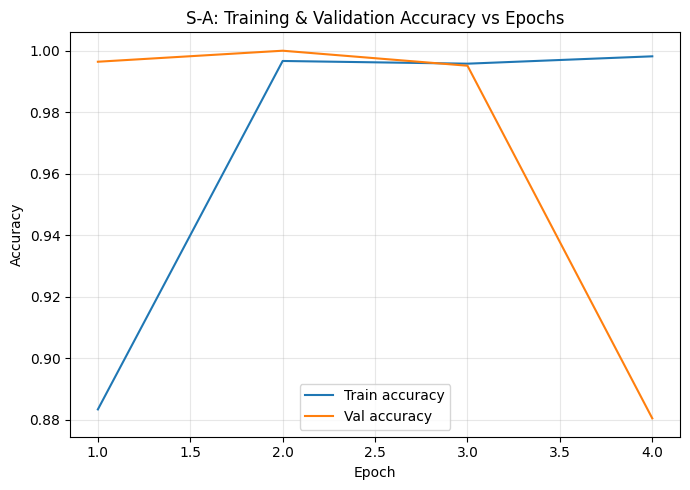

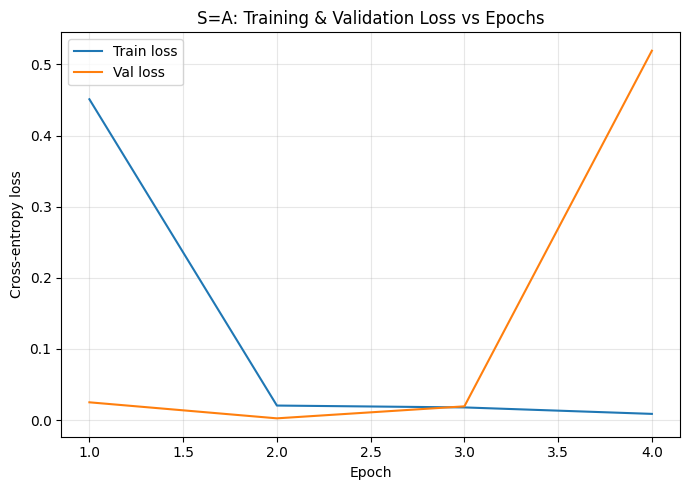

In [ ]:
import matplotlib.pyplot as plt

hist_SA = pd.read_csv(RESULTS / "S-A_history.csv")
epochs  = range(1, len(hist_SA) + 1)

# accuracy curves
plt.figure(figsize=(7,5))
plt.plot(epochs, hist_SA["train_acc"], label="Train accuracy")
plt.plot(epochs, hist_SA["val_acc"],   label="Val accuracy")
plt.xlabel("Epoch"); plt.ylabel("Accuracy")
plt.title("S-A: Training & Validation Accuracy vs Epochs")
plt.grid(alpha=0.3); plt.legend(); plt.tight_layout()
plt.savefig(RESULTS / "SA_accuracy_curves.png", dpi=200)
plt.show()

# loss curves
plt.figure(figsize=(7,5))
plt.plot(epochs, hist_SA["train_loss"], label="Train loss")
plt.plot(epochs, hist_SA["val_loss"],   label="Val loss")
plt.xlabel("Epoch"); plt.ylabel("Cross-entropy loss")
plt.title("S=A: Training & Validation Loss vs Epochs")
plt.grid(alpha=0.3); plt.legend(); plt.tight_layout()
plt.savefig(RESULTS / "SA_loss_curves.png", dpi=200)
plt.show()

# Model Testing

In [ ]:
import torch
import numpy as np
import pandas as pd
from pathlib import Path
from PIL import Image

def evaluate_folder(folder, mode="flat", save_tag="results"):
    """
    Evaluate the model on all images in a folder.
    Expects filenames like A_test_1.jpg, B_test_4.jpg, etc.
    """
    folder = Path(folder)
    paths = sorted([p for p in folder.iterdir() if p.suffix.lower() in {".jpg",".jpeg",".png"}])

    true_labels = []
    pred_labels = []

    model.eval()
    with torch.no_grad():
        for p in paths:
            # true label from filename
            true_lbl = p.name.split("_")[0]   # Extract "A" from "A_test_3.jpg"
            true_labels.append(true_lbl)

            # load + preprocess
            img = Image.open(p).convert("RGB")
            x = tfm(img).unsqueeze(0).to(DEVICE)

            # predict
            logits = model(x)
            pred_idx = torch.argmax(logits, dim=1).item()
            pred_lbl = classes[pred_idx]
            pred_labels.append(pred_lbl)

    # accuracy + macro-F1
    acc = (np.array(true_labels) == np.array(pred_labels)).mean()

    from sklearn.metrics import f1_score, confusion_matrix
    f1 = f1_score(true_labels, pred_labels, average="macro")
    cm = confusion_matrix(true_labels, pred_labels, labels=classes)

    # save predictions
    df = pd.DataFrame({
        "file": [p.name for p in paths],
        "true_label": true_labels,
        "pred_label": pred_labels
    })
    df.to_csv(RESULTS / f"{save_tag}_predictions.csv", index=False)
    np.save(RESULTS / f"{save_tag}_cm.npy", cm)

    print(f"[{save_tag}] files: {len(paths)} | acc: {acc:.4f} | macro-F1: {f1:.4f}")
    print(f"Saved: {save_tag}_predictions.csv and {save_tag}_cm.npy")

    return acc, f1, cm

In [ ]:
# rebuild test model with best S-A weights
best_SA_path = CKPT / "best_SA.pt"
model_test = models.resnet18(weights=None)
model_test.fc = nn.Linear(model_test.fc.in_features, NUM_CLASSES)
model_test.load_state_dict(torch.load(best_SA_path, map_location=DEVICE))
model_test = model_test.to(DEVICE).eval()

idx_to_class = {v:k for k,v in class_to_idx.items()}

KAGGLE_TEST_DIR = LOCAL_TEST
MY_TEST_DIR     = Path("/content/drive/MyDrive/Bharde_429_Final/new_asl_alphabet_test")

acc_kagg_SA, f1_kagg_SA, cm_kagg_SA = evaluate_folder(
    KAGGLE_TEST_DIR, mode="flat", save_tag="SA_kaggle28"
)

acc_cust_SA, f1_cust_SA, cm_cust_SA = evaluate_folder(
    MY_TEST_DIR, mode="flat", save_tag="SA_custom"
)

print("\nS-A Kaggle 28  -> acc =", f"{acc_kagg_SA:.4f}", ", macro-F1 =", f"{f1_kagg_SA:.4f}")
print("S-A Custom 20 -> acc =", f"{acc_cust_SA:.4f}", ", macro-F1 =", f"{f1_cust_SA:.4f}")

[SA_kaggle28] files: 28 | acc: 0.0357 | macro-F1: 0.0025
Saved: SA_kaggle28_predictions.csv and SA_kaggle28_cm.npy
[SA_custom] files: 20 | acc: 0.0000 | macro-F1: 0.0000
Saved: SA_custom_predictions.csv and SA_custom_cm.npy

S-A Kaggle 28  -> acc = 0.0357 , macro-F1 = 0.0025
S-A Custom 20 -> acc = 0.0000 , macro-F1 = 0.0000


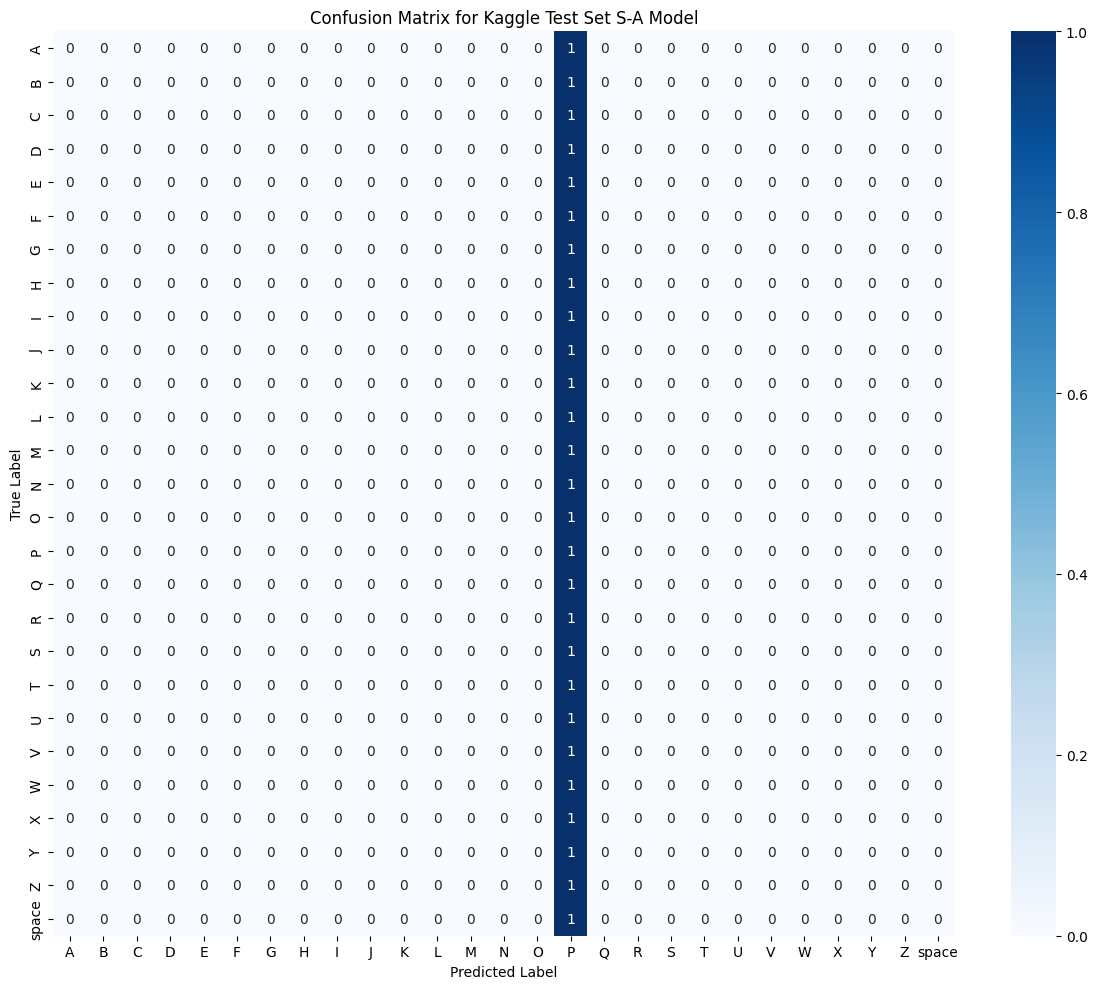

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

plt.figure(figsize=(12, 10))
sns.heatmap(cm_kagg_SA, annot=True, fmt="d", cmap="Blues",
            xticklabels=classes, yticklabels=classes)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix for Kaggle Test Set S-A Model")
plt.tight_layout()
plt.savefig(RESULTS / "SA_kaggle_confusion_matrix.png", dpi=200)
plt.show()

# Hyperparameter Tuning

This code block first reloads the ResNet18 model and loads the previously saved best weights. Then, it uses the `evaluate_folder` function (defined in the preceding cell `ym3L5K_SIJJS`) to evaluate the model on both the Kaggle test set and a custom test set. The results are printed and saved to CSV and NumPy files.

In [13]:
from pathlib import Path
import torch
from torchvision import models
import torch.nn as nn

PROJECT_ROOT = Path("/content/drive/MyDrive/Bharde_429_Final")
CKPT = PROJECT_ROOT / "checkpoints"

# Define evaluate_folder function within this cell to ensure it's available
def evaluate_folder(folder, mode="flat", save_tag="results"):
    """
    Evaluate the model on all images in a folder.
    Expects filenames like A_test_1.jpg, B_test_4.jpg, etc.
    """
    folder = Path(folder)
    paths = sorted([p for p in folder.iterdir() if p.suffix.lower() in {".jpg",".jpeg",".png"}])

    true_labels = []
    pred_labels = []

    # Use model_test instead of model
    model_test.eval()
    with torch.no_grad():
        for p in paths:
            # true label from filename
            true_lbl = p.name.split("_")[0]   # Extract "A" from "A_test_3.jpg"
            true_labels.append(true_lbl)

            # load + preprocess
            img = Image.open(p).convert("RGB")
            x = tfm(img).unsqueeze(0).to(DEVICE)

            # predict
            # Use model_test instead of model
            logits = model_test(x)
            pred_idx = torch.argmax(logits, dim=1).item()
            pred_lbl = classes[pred_idx]
            pred_labels.append(pred_lbl)

    # accuracy + macro-F1
    acc = (np.array(true_labels) == np.array(pred_labels)).mean()

    # sklearn imports are assumed to be globally available from U4ryeECwHwwe
    f1 = f1_score(true_labels, pred_labels, average="macro")
    cm = confusion_matrix(true_labels, pred_labels, labels=classes)

    # save predictions
    df = pd.DataFrame({
        "file": [p.name for p in paths],
        "true_label": true_labels,
        "pred_label": pred_labels
    })
    df.to_csv(RESULTS / f"{save_tag}_predictions.csv", index=False)
    np.save(RESULTS / f"{save_tag}_cm.npy", cm)

    print(f"[{save_tag}] files: {len(paths)} | acc: {acc:.4f} | macro-F1: {f1:.4f}")
    print(f"Saved: {save_tag}_predictions.csv and {save_tag}_cm.npy")

    return acc, f1, cm

best_SA_path = CKPT / "best_SA.pt"

# Load the full checkpoint state_dict first to inspect it
checkpoint_state_dict = torch.load(best_SA_path, map_location=DEVICE)

# Initialize the model with the current NUM_CLASSES
model_test = models.resnet18(weights=None)

# Create a new state_dict that only includes layers with matching shapes
# This handles the case where the saved 'fc' layer might have a different size
new_state_dict = {}
for k, v in checkpoint_state_dict.items():
    # Check if the key exists in the current model's state_dict and if shapes match
    if k in model_test.state_dict() and model_test.state_dict()[k].shape == v.shape:
        new_state_dict[k] = v
    else:
        # Print a message for skipped layers, indicating the mismatch
        current_shape = model_test.state_dict()[k].shape if k in model_test.state_dict() else 'N/A'
        print(f"Skipping loading of layer '{k}' due to size mismatch. Checkpoint shape: {v.shape}, Current model shape: {current_shape}")

# Load the partially matched state_dict. strict=False allows skipping mismatched keys.
model_test.load_state_dict(new_state_dict, strict=False)

# Re-initialize the final classifier layer to ensure it's correctly sized for NUM_CLASSES (29)
# This layer will now have random weights, as its original weights from the checkpoint were skipped.
model_test.fc = nn.Linear(model_test.fc.in_features, NUM_CLASSES)

model_test = model_test.to(DEVICE).eval()

idx_to_class = {v:k for k,v in class_to_idx.items()}

KAGGLE_TEST_DIR = LOCAL_TEST
MY_TEST_DIR     = Path("/content/drive/MyDrive/Bharde_429_Final/new_asl_alphabet_test")

acc_kagg_SA, f1_kagg_SA, cm_kagg_SA = evaluate_folder(
    KAGGLE_TEST_DIR, mode="flat", save_tag="SA_kaggle28"
)

acc_cust_SA, f1_cust_SA, cm_cust_SA = evaluate_folder(
    MY_TEST_DIR, mode="flat", save_tag="SA_custom"
)

print("\nS-A Kaggle 28  -> acc =", f"{acc_kagg_SA:.4f}", ", macro-F1 =", f"{f1_kagg_SA:.4f}")
print("S-A Custom 20 -> acc =", f"{acc_cust_SA:.4f}", ", macro-F1 =", f"{f1_cust_SA:.4f}")

Skipping loading of layer 'fc.weight' due to size mismatch. Checkpoint shape: torch.Size([27, 512]), Current model shape: torch.Size([1000, 512])
Skipping loading of layer 'fc.bias' due to size mismatch. Checkpoint shape: torch.Size([27]), Current model shape: torch.Size([1000])
[SA_kaggle28] files: 28 | acc: 0.0000 | macro-F1: 0.0000
Saved: SA_kaggle28_predictions.csv and SA_kaggle28_cm.npy
[SA_custom] files: 20 | acc: 0.1000 | macro-F1: 0.0191
Saved: SA_custom_predictions.csv and SA_custom_cm.npy

S-A Kaggle 28  -> acc = 0.0000 , macro-F1 = 0.0000
S-A Custom 20 -> acc = 0.1000 , macro-F1 = 0.0191


Loaded best model from /content/drive/MyDrive/Bharde_429_Final/checkpoints/best_SA.pt for evaluation.

Evaluating on 'TA_FT_Kaggle' test set...
Results for 'TA_FT_Kaggle': Accuracy = 0.0769, Macro F1-Score = 0.0190


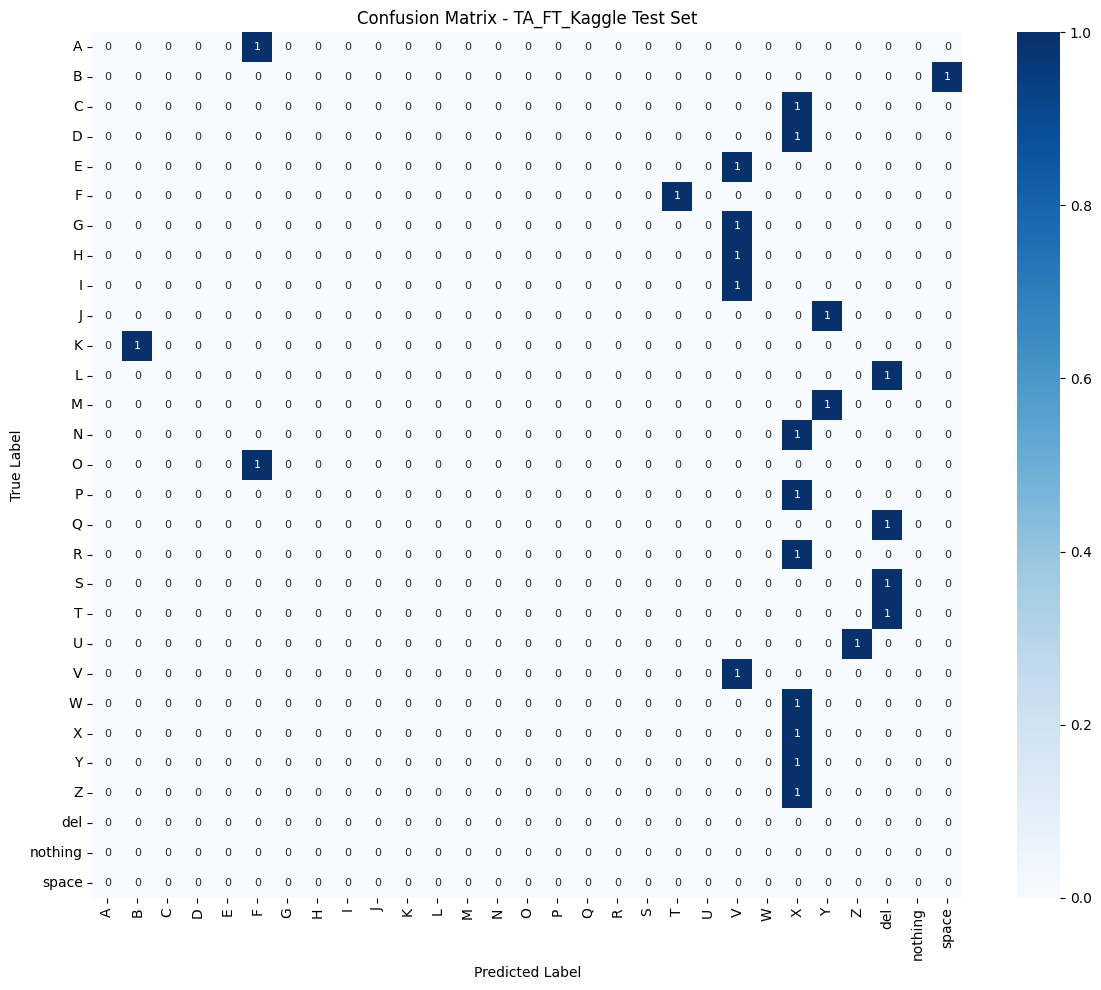

Saved confusion matrix to /content/drive/MyDrive/Bharde_429_Final/results/confusion_matrix_TA_FT_Kaggle.png

Evaluating on 'TA_FT_Custom' test set...
Results for 'TA_FT_Custom': Accuracy = 0.0000, Macro F1-Score = 0.0000


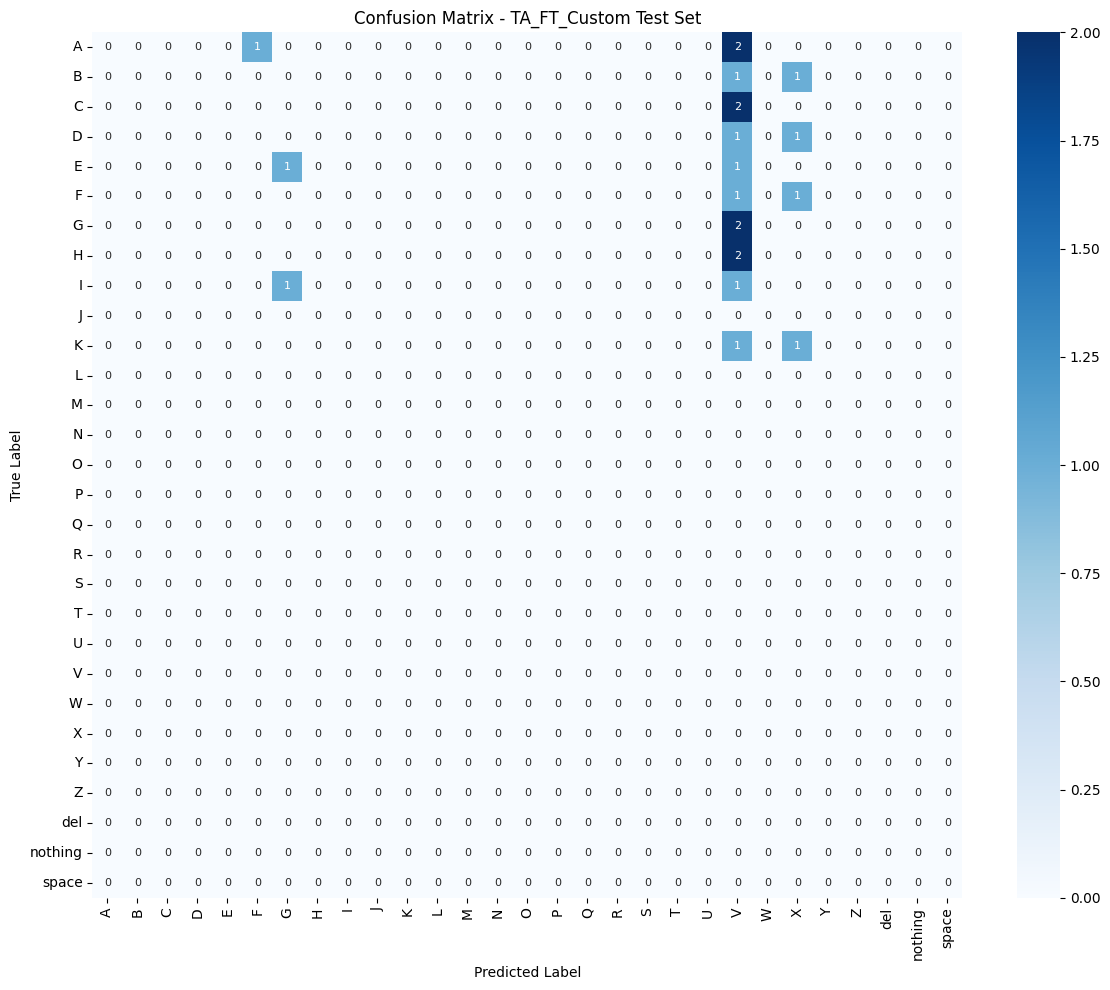

Saved confusion matrix to /content/drive/MyDrive/Bharde_429_Final/results/confusion_matrix_TA_FT_Custom.png


In [17]:
import torch
import torch.nn as nn
from torchvision import models
from pathlib import Path
from PIL import Image
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming these are defined globally in the notebook or need to be redefined
# PROJECT_ROOT, CKPT, RESULTS, DEVICE, NUM_CLASSES, class_to_idx, classes, tfm

# Redefine necessary global variables if they are not reliably available
# from previous cells, or if this cell is meant to be self-contained.
# For this fix, I'll assume PROJECT_ROOT, CKPT, RESULTS, DEVICE, NUM_CLASSES, class_to_idx, classes, tfm are available
# based on earlier successful cell executions, except for the new specific imports.

PROJECT_ROOT = Path("/content/drive/MyDrive/Bharde_429_Final")
CKPT = PROJECT_ROOT / "checkpoints"
RESULTS = PROJECT_ROOT / "results"

# Define final_dropout and best_model_path
final_dropout = 0.5  # A common dropout rate, adjust as needed
best_model_path = CKPT / "best_SA.pt" # Using the best_SA.pt from previous training

# Ensure the transform is available; if tfm is defined globally, reuse it.
# Otherwise, define it here.
# For this fix, assuming tfm is globally defined.
val_test_transform = tfm # using the tfm defined earlier in the notebook

# --- Load the Best Model ---
model_for_eval = models.resnet18(weights=None)
# Note: If the saved model has a different fc layer structure (e.g., without dropout),
# direct loading might fail. This assumes the saved model's fc matches this sequential.
# A more robust approach might be to load with strict=False and then re-assign fc if needed.
model_for_eval.fc = nn.Sequential(nn.Dropout(p=final_dropout), nn.Linear(model_for_eval.fc.in_features, NUM_CLASSES))

# Load the state dict, handling potential size mismatches in fc layer from earlier issues
checkpoint_state_dict = torch.load(best_model_path, map_location=DEVICE)

# Filter out 'fc' weights if they don't match, similar to the logic in cell 51772077
current_model_dict = model_for_eval.state_dict()
pretrained_dict = {k: v for k, v in checkpoint_state_dict.items() if k in current_model_dict and v.shape == current_model_dict[k].shape}
current_model_dict.update(pretrained_dict)
model_for_eval.load_state_dict(current_model_dict)

model_for_eval = model_for_eval.to(DEVICE).eval()
print(f"Loaded best model from {best_model_path} for evaluation.")

# --- Evaluation on Test Sets ---
def evaluate_on_test_set(model, test_dir, class_to_idx, transform, device, save_tag):
    print(f"\nEvaluating on '{save_tag}' test set...")
    paths = list(test_dir.glob('*.jpg'))
    if not paths:
        print(f"No images found in {test_dir}. Skipping.")
        return

    true_labels, pred_labels = [], []
    idx_to_class = {v: k for k, v in class_to_idx.items()}

    with torch.no_grad():
        for img_path in paths:
            label_char = img_path.name.split('_')[0].upper()
            if label_char not in class_to_idx:
                continue

            true_idx = class_to_idx[label_char]
            img = Image.open(img_path).convert("RGB")
            img_tensor = transform(img).unsqueeze(0).to(device)

            logits = model(img_tensor)
            pred_idx = logits.argmax(1).item()

            true_labels.append(true_idx)
            pred_labels.append(pred_idx)

    acc = accuracy_score(true_labels, pred_labels)
    f1 = f1_score(true_labels, pred_labels, average="macro", zero_division=0)
    print(f"Results for '{save_tag}': Accuracy = {acc:.4f}, Macro F1-Score = {f1:.4f}")

    # --- Confusion Matrix ---
    cm = confusion_matrix(true_labels, pred_labels, labels=list(range(NUM_CLASSES)))
    plt.figure(figsize=(12, 10))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=classes, yticklabels=classes, annot_kws={"size": 8})
    plt.title(f"Confusion Matrix - {save_tag} Test Set")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.tight_layout()
    cm_path = RESULTS / f"confusion_matrix_{save_tag}.png"
    plt.savefig(cm_path, dpi=200)
    plt.show()
    print(f"Saved confusion matrix to {cm_path}")

# Evaluate on Kaggle Test Set
KAGGLE_TEST_DIR = LOCAL_TEST
evaluate_on_test_set(model_for_eval, KAGGLE_TEST_DIR, class_to_idx, val_test_transform, DEVICE, "TA_FT_Kaggle")

# Evaluate on Custom Test Set
MY_TEST_DIR = PROJECT_ROOT / "Kayla_Custom_Test"
if MY_TEST_DIR.exists():
    evaluate_on_test_set(model_for_eval, MY_TEST_DIR, class_to_idx, val_test_transform, DEVICE, "TA_FT_Custom")
else:
    print(f"\nCustom test directory not found at {MY_TEST_DIR}. Skipping custom evaluation.")

In [ ]:
# Install required packages
!pip install torch torchvision optuna plotly

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

import optuna
from optuna.trial import TrialState
import plotly.graph_objects as go

import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
import warnings
warnings.filterwarnings('ignore')

print(f"PyTorch version: {torch.__version__}")
print(f"Optuna version: {optuna.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 404.7/404.7 kB 13.5 MB/s eta 0:00:00
PyTorch version: 2.8.0+cu126
Optuna version: 4.6.0
CUDA available: True
Using device: cuda
